# Regressing out cofounders

In this step we will take our pre-processed data set, and regress out sources of variation.

In [13]:
!git 

/d0/home/adamk/julian_analysis


In [1]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

import collections
%matplotlib inline

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.21.3 statsmodels==0.10.1


Load the AnnData matrix from the previous step. Create views for this AnnData matrix for each batch. Some of the automatically computed annotations (e.g. `n_cells` and `n_genes`) are not valid anymore, so let's remove them from the matrices.

In [2]:
adata = anndata.read_h5ad(os.path.join("write", "tgfb1-2.h5ad"))

In [3]:
batches = {batch : adata[adata.obs["batch"] == batch, :] for batch in set(adata.obs["batch"])}

In [4]:
for batch in batches.values():
    del batch.var["n_cells"]
    del batch.obs["n_genes"]

In [5]:
batches

{'control': View of AnnData object with n_obs × n_vars = 1605 × 4709 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original'
     layers: 'ambiguous', 'spliced', 'unspliced',
 'TGFB1': View of AnnData object with n_obs × n_vars = 1893 × 4709 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original'
     layers: 'ambiguous', 'spliced', 'unspliced',
 'BMP9': View of AnnData object with n_obs × n_vars = 1256 × 4709 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original'
     layers: 'ambiguous', 'spliced', 'unspliced',
 'BMP9-TGFB1

## Scale data set

Gene variance alone could be a source of noise during analysis. We will scale the data set to achieve unit variance and zero mean, clipping values exceeding std 10.

In [6]:
for batch, matrix in batches.items():
    print("Scaling batch", batch)
    sc.pp.scale(matrix, max_value=10)

Scaling batch control
Scaling batch TGFB1


/d0/home/adamk/pysccnv/venv/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Scaling batch BMP9
Scaling batch BMP9-TGFB1


## Principal component analysis (PCA)

In order to visualize the differentiation in our data set, we will run principal component analysis on each individual cell as a form of dimensionality reduction. We will do this for both the global data set, as well as for each individual batch.

The first graph shows the PCA plot for the entire dataset and then broken down by batches.

PCA plot for whole data set
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02)


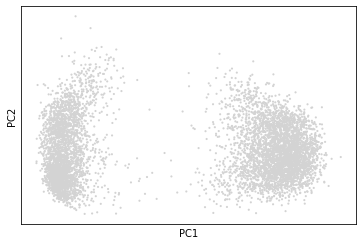

PCA plot for batch control
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


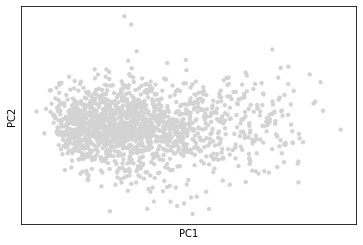

PCA plot for batch TGFB1
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


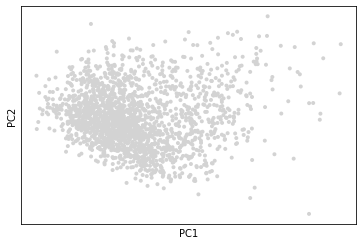

PCA plot for batch BMP9
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


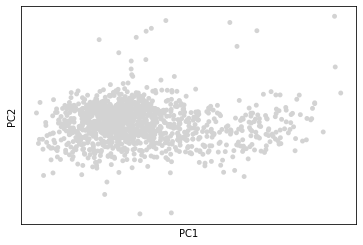

PCA plot for batch BMP9-TGFB1
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


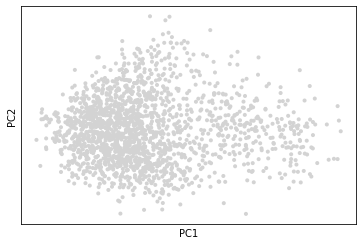

In [7]:
print("PCA plot for whole data set")
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

for batch, matrix in batches.items():
    print("PCA plot for batch", batch)
    sc.tl.pca(matrix, svd_solver='arpack')
    sc.pl.pca(matrix)

Overlay this plot with per-cell data sets to to see how these clusters vary by batch, percent of mito genes, counts, etc.

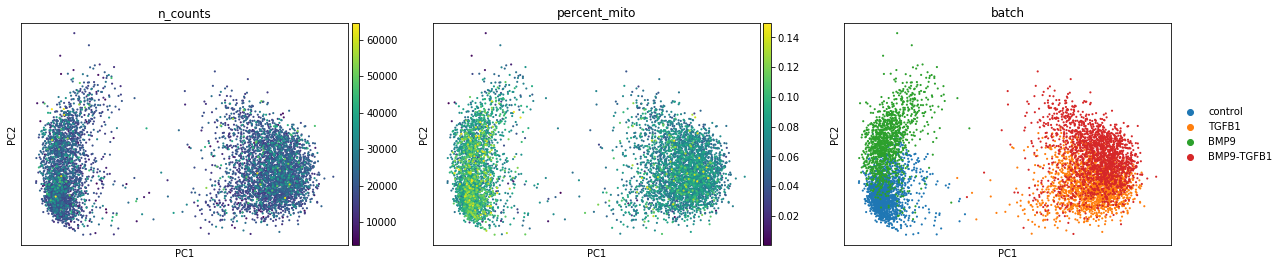

Plots for batch control


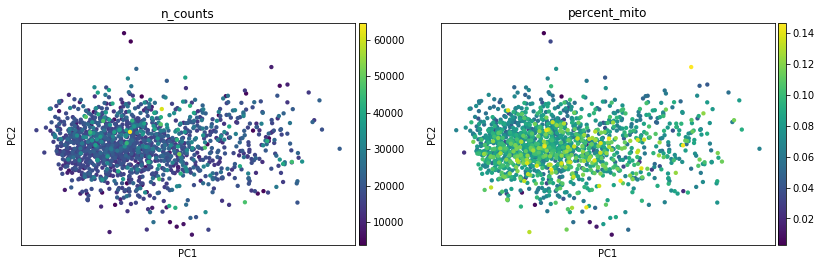

Plots for batch TGFB1


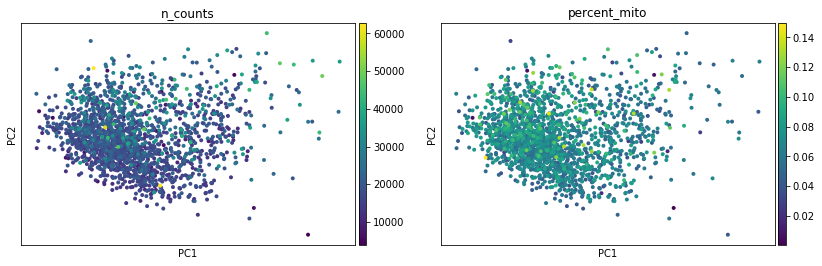

Plots for batch BMP9


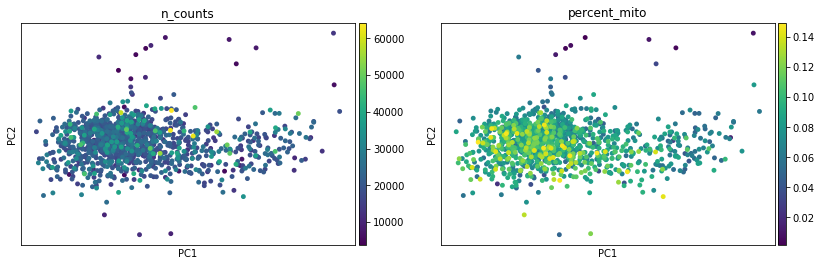

Plots for batch BMP9-TGFB1


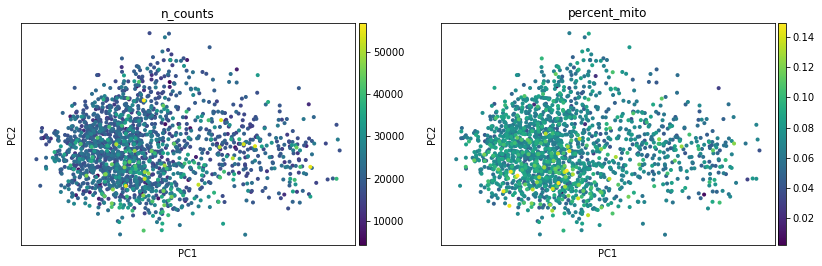

In [8]:
pca_data_points = ["n_counts", "percent_mito"]

sc.pl.pca(adata, color=pca_data_points + ["batch"])

for batch, matrix in batches.items():
    print("Plots for batch", batch)
    sc.pl.pca(matrix, color=pca_data_points)

## FIGURE (for paper)
Show batch, SERPINE1, CTGF, ID3, PLAUR

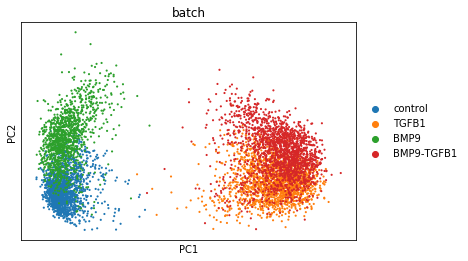

In [9]:
sc.pl.pca(adata, color=["batch"])

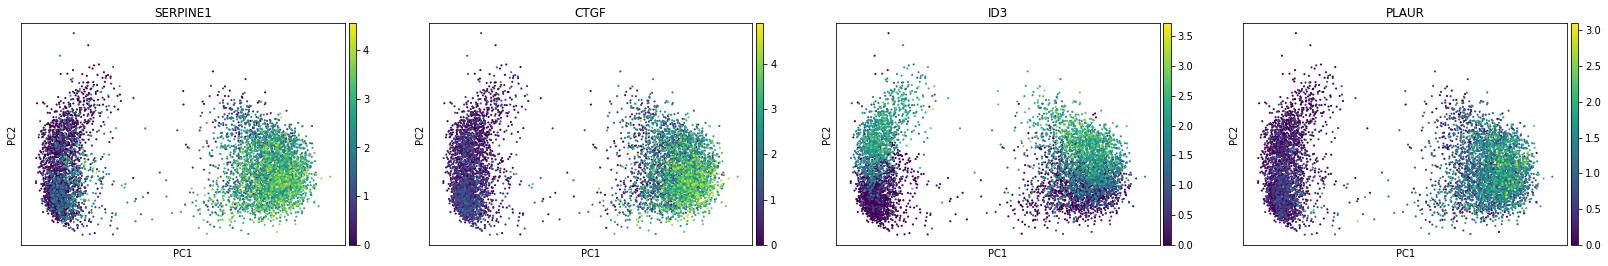

In [10]:
sc.pl.pca(adata, color=["SERPINE1", "CTGF", "ID3", "PLAUR"])

## Regressing out cell count

There seems to be some variation in cell counts that we would like to get rid of. This can be done by using simple linear regression to control for the noise introduced by this cofounder. Since we have two clusters, we will want to run this process on each batch individually, rather than the matrix containing both.

In [11]:
for matrix in batches.values():
    sc.pp.regress_out(matrix, ['n_counts'])
    sc.pp.scale(matrix)

regressing out ['n_counts']


/d0/home/adamk/pysccnv/venv/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:179: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

We should see a change in the PCA plot from before and after this took place, especially regarding the difference in total counts after regressing out that variable.

In [ ]:
for batch, matrix in batches.items():
    print("Plots for batch", batch, "after cell count regression")
    sc.tl.pca(matrix, svd_solver='arpack')
    sc.pl.pca(matrix, color=['n_counts'])

## Regress out cell cycle

There is also considerable variation regarding the stage of development a cell is in at any given point. The least developed progenitor cells behave differently than the most developed differentiated cells. We mostly care about differentiation in the behavior of cells, but cells also undergo other processes that we do not want to look at and wish to control for. One of these is the cell cycle, in particular the effect that cell division has on how genes are transcribed within the cell.

We have [data](https://doi.org/10.1126/science.aad0501) of biomarkers for the S and G2M cell cycle stages. Let us use this data to compute a cell cycle score for these biomarkers and regress them out.

In [ ]:
biomarkers = {}
cell_cycle_genes = set()

First, load S cycle biomarkers:

In [ ]:
with open(os.path.join("data", "s_genes")) as f:
    biomarkers["S"] = set(map(str.strip, f))
    cell_cycle_genes = cell_cycle_genes.union(biomarkers["S"])

Then, load G2M cycle biomarkers:

In [ ]:
with open(os.path.join("data", "g2m_genes")) as f:
    biomarkers["G2M"] = set(map(str.strip, f))
    cell_cycle_genes = cell_cycle_genes.union(biomarkers["G2M"])

Get number of genes comprising each marker:

In [ ]:
{marker : len(biomarkers[marker]) for marker in biomarkers}

Get number of all cell cycle marker genes:

In [ ]:
len(cell_cycle_genes)

Find genes that are in the list but are not in our original list of genes. This may be due to an error in the processing that skipped a gene or different names being used in the literature. Let us correct for this.

In [ ]:
cell_cycle_genes - set(adata.uns["genes_original"])

In [ ]:
cell_cycle_genes.remove("FAM64A")
cell_cycle_genes.add("PIMREG")

In [ ]:
cell_cycle_genes.remove("HN1")
cell_cycle_genes.add("JPT1")

In [ ]:
cell_cycle_genes.remove("MLF1IP")
cell_cycle_genes.add("CENPU")

Check which of the genes are found in each batch from each marker, then compute cell cycle score based on those sets:

In [ ]:
for batch, matrix in batches.items():
    common_per_batch = {}
    
    for marker, markers in biomarkers.items():
        curr_genes = set(matrix.var.index)
        common = markers.intersection(curr_genes)
        
        print("Batch", batch, "has", len(common), "genes in common with marker", marker, ", which are", common)
        common_per_batch[marker] = common
    
    sc.tl.score_genes_cell_cycle(matrix, s_genes=common_per_batch["S"], g2m_genes=common_per_batch["G2M"])

In [ ]:
batches

After calculating these scores, let's color our existing PCA plot by the cell cycle stages. We can see from the uniformity that this effect was controlled for during the experiment. Let's also create a separate PCA plot only for the subset of the matrix that only contains the biomarker genes:

In [ ]:
for batch, matrix in batches.items():
    print("Plots for batch", batch, "before cell cycle regression, all genes")
    sc.pl.pca_scatter(matrix, color='phase')
    
    print("Plots for batch", batch, "before cell cycle regression, only cell cycle marker genes")
    curr_genes = set(matrix.var.index)
    matrix_cc = matrix[:, list(cell_cycle_genes.intersection(curr_genes))]
    sc.tl.pca(matrix_cc, svd_solver='arpack')
    sc.pl.pca_scatter(matrix_cc, color='phase')

Count how many cells are in each cycle according to this analysis.

In [ ]:
for batch, matrix in batches.items():
    print("Cell cycle phases for batch", batch)
    print(collections.Counter(matrix.obs["phase"]))

Despite this, let us regress out the cycle scores and recompute the PCA plots after the regression has taken place.

In [ ]:
for matrix in batches.values():
    sc.pp.regress_out(matrix, ['S_score', 'G2M_score'])
    sc.pp.scale(matrix)

In [ ]:
for batch, matrix in batches.items():
    print("Plots for batch", batch, "after cell cycle regression, all genes")
    sc.pl.pca_scatter(matrix, color='phase')
    
    print("Plots for batch", batch, "after cell cycle regression,  only cell cycle marker genes")
    curr_genes = set(matrix.var.index)
    matrix_cc = matrix[:, list(cell_cycle_genes.intersection(curr_genes))]
    sc.tl.pca(matrix_cc, svd_solver='arpack')
    sc.pl.pca_scatter(matrix_cc, color='phase')

## Save data to disk

Let's save the progress we have made per individual batch.

In [ ]:
for batch, matrix in batches.items():
    filename = "tgfb1-3-" + batch + ".h5ad"
    filename = os.path.join("write", filename)
    matrix.write(filename)